In [1]:
import os
import random

from PIL import Image
import numpy as np
import pandas as pd
from glob import glob

import matplotlib.pyplot as plt

/tmp/ipykernel_21696/3469073324.py:6: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


### Test dataset

288개 (144개 폴더 * 좌, 우 두 개씩)

In [5]:
# 결과 불러오기
res_df = pd.read_csv('../output.csv')

# random으로 뽑기 위해 unique한 image_name을 뽑아냄 
uimg_names =  res_df['image_name'].unique().tolist()

# glob을 통해 img_path 전체를 받아오기
img_paths = glob(os.path.join("../data", "test", "*", "*", "*.png"))

In [6]:
# random으로 뽑은 image_name에 해당하는 img_path를 뽑아내기
path_dict = dict()
for img_path in img_paths:
    img_name = img_path.split("/")[-1]
    path_dict[img_name] = img_path

In [7]:
# random 추출
uimg_name = random.choice(uimg_names)

# 해당하는 img_path를 뽑아내기
img_path = path_dict[uimg_name]

# 해당하는 img의 결과값 뽑아내기
result = res_df[res_df['image_name'] == uimg_name]

In [8]:
# rle를 decode하는 함수를 정의합니다.
def rle_decode(mask_rle, shape):
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape)

In [9]:
# 빈 마스크를 만듭니다.
img = Image.open(img_path).convert('RGB')
decoded_mask = np.zeros((2048, 2048), dtype=np.uint8)

for idx, res in enumerate(result.values):
    _, cls_name, rle = res
    # nan (못잡았을 때)이면 빈 마스크를 만듭니다.
    try:    
        decoded_rle = rle_decode(rle, (2048, 2048))
        pil_decoded_rle = Image.fromarray(decoded_rle*255)
    except:
        pil_decoded_rle = np.zeros((2048, 2048), dtype=np.uint8)
        pil_decoded_rle = Image.fromarray(pil_decoded_rle*255)
    # 마스크를 합칩니다.
    decoded_mask += pil_decoded_rle

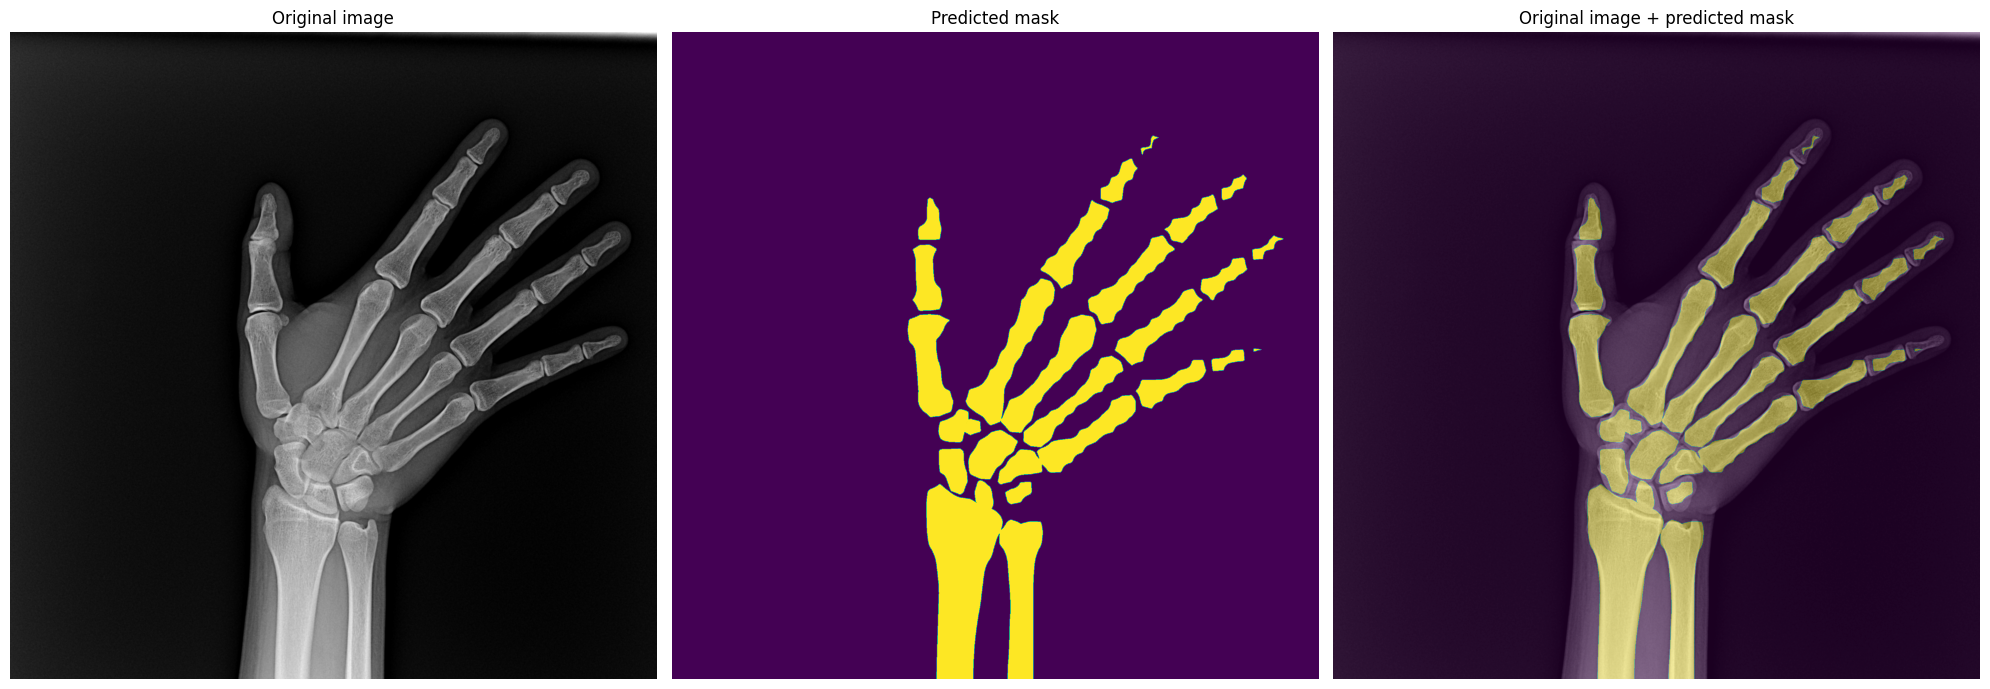

In [10]:
fig, axes = plt.subplots(1, 3, figsize=(20, 10))

axes[0].imshow(img)
axes[0].set_title('Original image')
axes[0].axis('off')

axes[1].imshow(decoded_mask)
axes[1].set_title('Predicted mask')
axes[1].axis('off') 

axes[2].imshow(img)
axes[2].imshow(decoded_mask, alpha=0.4)
axes[2].set_title('Original image + predicted mask')
axes[2].axis('off')

plt.tight_layout()
plt.show()